In [80]:
# import libaraies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
import warnings
from tensorflow.keras.callbacks import EarlyStopping

In [81]:
# import data from My Drive
df_nvidia = pd.read_csv("/content/drive/MyDrive/NVIDIA_STOCK.csv")

In [82]:
# Display the dataframe
df_nvidia.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,4.929879665374756,4.983749866485596,4.987500190734863,4.862500190734863,4.894499778747559,355616000
3,2018-01-03,5.254334926605225,5.3117499351501465,5.34250020980835,5.09375,5.102499961853027,914704000
4,2018-01-04,5.2820329666137695,5.339749813079834,5.451250076293945,5.317249774932861,5.394000053405762,583268000


In [83]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1699 non-null   object
 1   Adj Close  1698 non-null   object
 2   Close      1698 non-null   object
 3   High       1698 non-null   object
 4   Low        1698 non-null   object
 5   Open       1698 non-null   object
 6   Volume     1698 non-null   object
dtypes: object(7)
memory usage: 93.0+ KB


In [84]:
# Data Cleaning
# Remove unwanted rows
df_nvidia = df_nvidia.iloc[2:]
# Remove rows with missing values
df_nvidia = df_nvidia.dropna()


In [85]:
# Convert object into float
df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] = df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].apply(pd.to_numeric, errors='coerce')

In [86]:
# Handle missing values
df_nvidia.ffill(inplace=True)

In [87]:
# Convert date column to datetime
df_nvidia.rename(columns={'Price': 'Date'}, inplace=True)
df_nvidia['Date'] = pd.to_datetime(df_nvidia['Date'])
df_nvidia = df_nvidia.sort_values(by="Date").reset_index(drop=True)

In [88]:
# Display summary
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,4.929880,4.98375,4.98750,4.86250,4.89450,355616000
1,2018-01-03,5.254335,5.31175,5.34250,5.09375,5.10250,914704000
2,2018-01-04,5.282033,5.33975,5.45125,5.31725,5.39400,583268000
3,2018-01-05,5.326794,5.38500,5.42275,5.27700,5.35475,580124000
4,2018-01-08,5.490012,5.55000,5.62500,5.46450,5.51000,881216000


In [89]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1697 non-null   datetime64[ns]
 1   Adj Close  1697 non-null   float64       
 2   Close      1697 non-null   float64       
 3   High       1697 non-null   float64       
 4   Low        1697 non-null   float64       
 5   Open       1697 non-null   float64       
 6   Volume     1697 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 92.9 KB


In [90]:
# Missing values
df_nvidia.isna().sum()

,0
Date,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [91]:
# Duplicated values
df_nvidia.duplicated().sum()

np.int64(0)

In [92]:
# Summary statistics
df_nvidia.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,1697,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1.697000e+03
mean,2021-05-16 04:49:21.461402368,24.797593,24.828411,25.295239,24.315422,24.823341,4.716865e+08
min,2018-01-02 00:00:00,3.151430,3.177000,3.249500,3.111500,3.162250,9.788400e+07
25%,2019-09-10 00:00:00,6.113620,6.161750,6.250000,6.064250,6.166250,3.278440e+08
50%,2021-05-17 00:00:00,13.985092,14.015750,14.243500,13.750000,14.033750,4.349650e+08
75%,2023-01-23 00:00:00,27.088902,27.104000,27.496000,26.613001,27.077999,5.708320e+08
max,2024-09-30 00:00:00,135.559067,135.580002,140.759995,132.419998,139.800003,2.511528e+09
std,NaN,29.221442,29.216014,29.811740,28.570804,29.240504,2.093254e+08


In [93]:
# display correlation
df_nvidia.corr()

,Date,Adj Close,Close,High,Low,Open,Volume
Date,1.000000,0.766104,0.765909,0.765275,0.766219,0.765174,-0.105869
Adj Close,0.766104,1.000000,1.000000,0.999662,0.999763,0.999329,-0.113866
Close,0.765909,1.000000,1.000000,0.999662,0.999763,0.999330,-0.113864
High,0.765275,0.999662,0.999662,1.000000,0.999673,0.999780,-0.109508
Low,0.766219,0.999763,0.999763,0.999673,1.000000,0.999668,-0.117262
Open,0.765174,0.999329,0.999330,0.999780,0.999668,1.000000,-0.112821
Volume,-0.105869,-0.113866,-0.113864,-0.109508,-0.117262,-0.112821,1.000000


In [94]:
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,4.929880,4.98375,4.98750,4.86250,4.89450,355616000
1,2018-01-03,5.254335,5.31175,5.34250,5.09375,5.10250,914704000
2,2018-01-04,5.282033,5.33975,5.45125,5.31725,5.39400,583268000
3,2018-01-05,5.326794,5.38500,5.42275,5.27700,5.35475,580124000
4,2018-01-08,5.490012,5.55000,5.62500,5.46450,5.51000,881216000


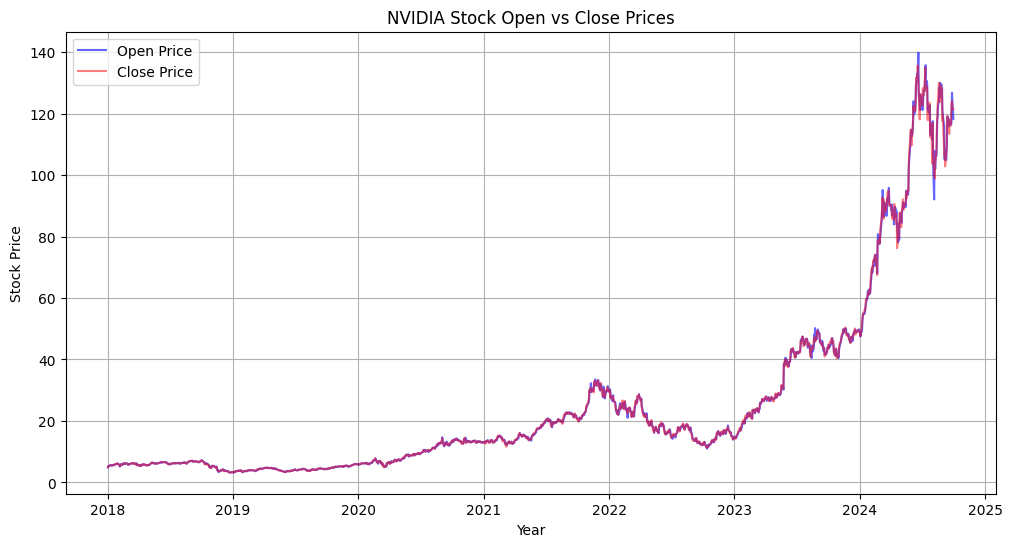

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(df_nvidia['Date'], df_nvidia['Open'], label="Open Price", color='blue', alpha=0.6)
plt.plot(df_nvidia['Date'], df_nvidia['Close'], label="Close Price", color='red', alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Stock Price")
plt.title("NVIDIA Stock Open vs Close Prices")
plt.legend()
plt.grid(True)
plt.show()

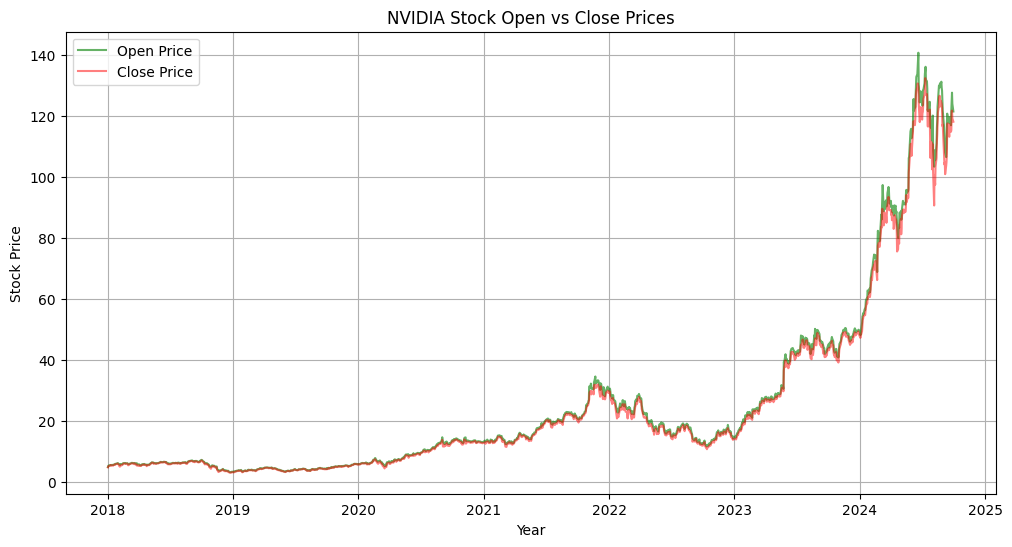

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(df_nvidia['Date'], df_nvidia['High'], label="Open Price", color='green', alpha=0.6)
plt.plot(df_nvidia['Date'], df_nvidia['Low'], label="Close Price", color='red', alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Stock Price")
plt.title("NVIDIA Stock Open vs Close Prices")
plt.legend()
plt.grid(True)
plt.show()

In [97]:
#df_nvidia = df_nvidia.drop(columns='Date')

In [98]:
#histogram
#df_nvidia.hist(bins=50, color="green", figsize=(20,15))
#plt.show()

In [99]:
# Looking at some real data, where we don't know the number of clusters already
#for col in df_nvidia.columns:
#    df_nvidia[col] = pd.to_numeric(df_nvidia[col])

#sns.pairplot(df_nvidia, corner=True)
#plt.show()

In [100]:
# Show correlation
#fig, ax = plt.subplots(figsize = (20, 12))
#ax = sns.heatmap(df_nvidia.corr(), cmap='viridis', cbar=True, annot=True, linewidths=0.2,ax=ax)
# save image
#plt.savefig('corr.png')
#plt.show()

In [101]:
# Feature Engineering (Moving Averages and Volatility)

# Calculate the 50-day Simple Moving Average (SMA), which smooths the closing price
# by averaging it over the last 50 days to identify short-term trends.
df_nvidia['SMA_50'] = df_nvidia['Close'].rolling(window=50).mean()

# Calculate the 200-day Simple Moving Average (SMA), which smooths the closing price
# over the last 200 days to identify long-term trends.
df_nvidia['SMA_200'] = df_nvidia['Close'].rolling(window=200).mean()

# Calculate the 50-day rolling standard deviation (Volatility), which measures the
# dispersion of closing prices over the last 50 days, indicating market volatility.
df_nvidia['Volatility'] = df_nvidia['Close'].rolling(window=50).std()

df_nvidia.dropna(inplace=True)

In [102]:
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume,SMA_50,SMA_200,Volatility
199,2018-10-16,6.090191,6.14575,6.15700,5.94850,5.99825,408712000,6.656860,6.178069,0.321654
200,2018-10-17,6.021566,6.07650,6.24700,6.02700,6.20850,329668000,6.649915,6.183533,0.330420
201,2018-10-18,5.934114,5.98825,6.18525,5.92725,6.14650,524020000,6.640470,6.186915,0.342474
202,2018-10-19,5.677456,5.72925,6.06375,5.69250,6.04400,613608000,6.626825,6.188863,0.364656
203,2018-10-22,5.728243,5.78050,5.88300,5.67675,5.78200,368844000,6.615040,6.190840,0.382232


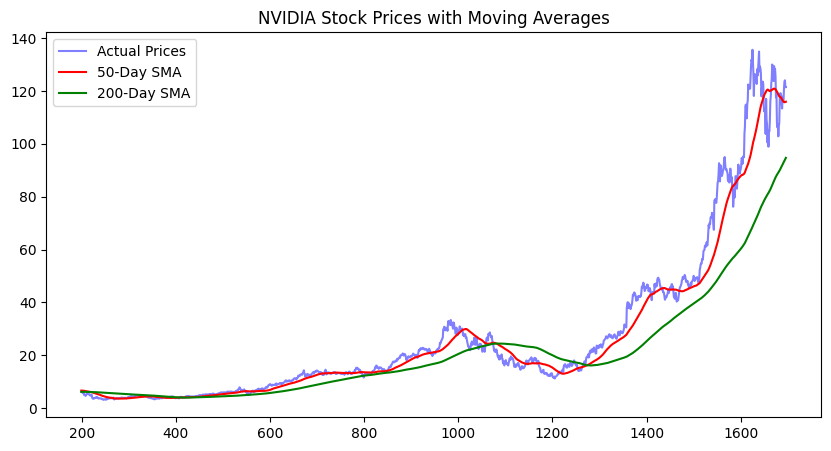

In [103]:
# Plot Moving Averages with Actual Prices
plt.figure(figsize=(10, 5))
plt.plot(df_nvidia.index, df_nvidia["Close"], label="Actual Prices", color="blue", alpha=0.5)
plt.plot(df_nvidia.index, df_nvidia["SMA_50"], label="50-Day SMA", color="red")
plt.plot(df_nvidia.index, df_nvidia["SMA_200"], label="200-Day SMA", color="green")
plt.legend()
plt.title("NVIDIA Stock Prices with Moving Averages")
plt.show()

In [104]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1498 entries, 199 to 1696
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1498 non-null   datetime64[ns]
 1   Adj Close   1498 non-null   float64       
 2   Close       1498 non-null   float64       
 3   High        1498 non-null   float64       
 4   Low         1498 non-null   float64       
 5   Open        1498 non-null   float64       
 6   Volume      1498 non-null   int64         
 7   SMA_50      1498 non-null   float64       
 8   SMA_200     1498 non-null   float64       
 9   Volatility  1498 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 128.7 KB


In [105]:
# Define features and target
# 'SMA_50', 'SMA_200', 'Volatility'
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
target = 'Close'

In [106]:
X = df_nvidia[features]
y = df_nvidia[target]

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [107]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)

In [108]:
# Random Forest Regressor
random_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_model.fit(X_train, y_train)
y_pred_rf = random_model.predict(X_test)

In [109]:
# LSTM (Deep Learning)
X_lstm = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

# **Apply Early Stopping (Stop training when loss < 0.001)**
early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.001, verbose=1, restore_best_weights=True)

lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
# **Train LSTM Model with Early Stopping**
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=250, batch_size=32, callbacks=[early_stopping], verbose=1)

y_pred_lstm = lstm_model.predict(X_test_lstm)

Epoch 1/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1510.7395
Epoch 2/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1256.3811
Epoch 3/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1066.8315
Epoch 4/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1101.5227
Epoch 5/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 963.1200
Epoch 6/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 958.6838
Epoch 7/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1003.3734
Epoch 8/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 781.6381
Epoch 9/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 720.4612
Epoch 10/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 634.4841
Epoch 11/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 765.4813
Epoch 12/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 576.5219
Epoch 13/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 694.6213
Epoch 14/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 565.1490
Epoch 15/250
38/38 ━━━━━━━━━━━━

In [110]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Performance of {model_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

In [111]:
evaluate_model(y_test, y_pred_lr, "Linear Regression")

Performance of Linear Regression:
MAE: 0.00
RMSE: 0.00
R² Score: 1.00


In [112]:
evaluate_model(y_test, y_pred_rf, "Random Forest")

Performance of Random Forest:
MAE: 0.10
RMSE: 0.27
R² Score: 1.00


In [113]:
evaluate_model(y_test_lstm, y_pred_lstm.flatten(), "LSTM")

Performance of LSTM:
MAE: 0.17
RMSE: 0.50
R² Score: 1.00


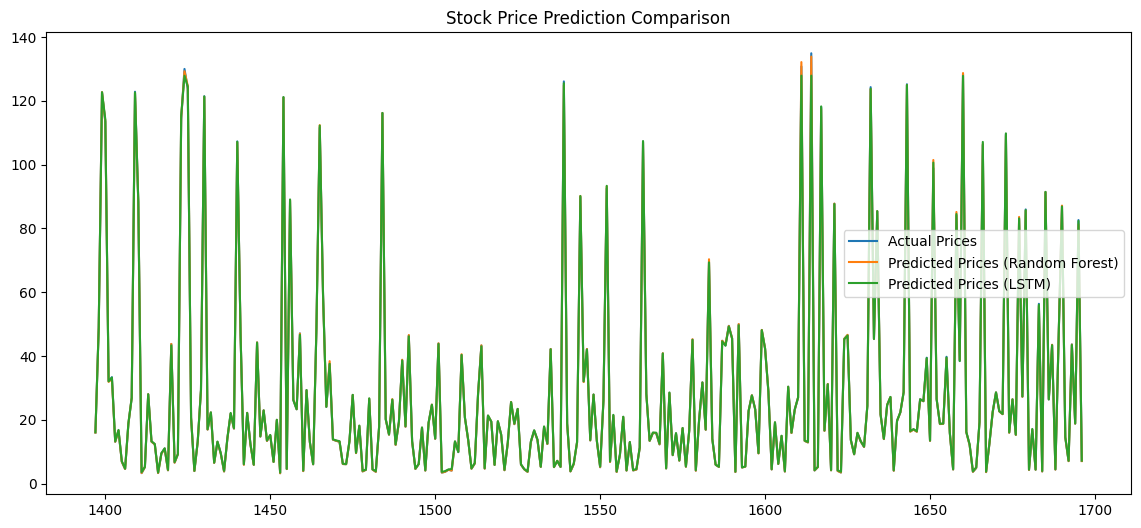

In [114]:
# Time Horizon Impact
plt.figure(figsize=(14, 6))
plt.plot(df_nvidia.index[-len(y_test):], y_test.values, label='Actual Prices')
plt.plot(df_nvidia.index[-len(y_test):], y_pred_rf, label='Predicted Prices (Random Forest)')
plt.plot(df_nvidia.index[-len(y_test):], y_pred_lstm.flatten(), label='Predicted Prices (LSTM)')
plt.legend()
plt.title("Stock Price Prediction Comparison")
plt.show()

In [115]:
arima_model = ARIMA(df_nvidia['Close'], order=(5, 1, 0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=len(y_test))

evaluate_model(y_test, arima_pred, "ARIMA")

# Conclusion
print("Comparison Complete. Evaluate the models based on MAE, RMSE, and R².")

Performance of ARIMA:
MAE: 93.08
RMSE: 97.90
R² Score: -8.64
Comparison Complete. Evaluate the models based on MAE, RMSE, and R².


In [120]:
#!pip install pmdarima
!pip install --upgrade pmdarima

In [121]:
from pmdarima import auto_arima

# Ignore warnings from statsmodels
#warnings.filterwarnings("ignore")

# **Check Stationarity with Augmented Dickey-Fuller (ADF) Test**
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("ADF Test Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The data is stationary (No transformation needed).")
    else:
        print("The data is NOT stationary (Differencing required).")

# Test for stationarity
check_stationarity(df_nvidia['Close'])

# **Train-Test Split (80-20)**
train_size = int(len(df_nvidia) * 0.8)
train, test = df_nvidia['Close'][:train_size], df_nvidia['Close'][train_size:]

# **Auto-Select ARIMA Parameters using Auto ARIMA**
auto_arima_model = auto_arima(train, seasonal=False, stepwise=True, trace=True, suppress_warnings=True)
best_p, best_d, best_q = auto_arima_model.order

# **Train ARIMA Model**
arima_model = ARIMA(train, order=(best_p, best_d, best_q))
arima_result = arima_model.fit()

# **Forecasting**
forecast_arima = arima_result.forecast(steps=len(test))

# **Visualization: ARIMA Predictions vs. Actual Prices with Proper Date Formatting**
plt.figure(figsize=(12, 6))
plt.plot(df_nvidia.index[train_size:], test, label="Actual Prices", color="blue")
plt.plot(df_nvidia.index[train_size:], forecast_arima, label="ARIMA Predictions", color="green", linestyle='dashed')

# **Fix X-Axis Date Formatting**
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit number of x-axis labels

plt.legend()
plt.title("Stock Price Predictions: ARIMA Model vs. Actual Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.grid(True)
plt.show()

# **Evaluation Metrics for ARIMA**
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

(mae_arima, rmse_arima)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject